# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=c7d7da47f00345939604ab812cffd8eb21a050065de3497fe2bf9c657b157961
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=4f2468dad08d8379050ed4756a143855692762073358e3a220b60804eb0d24ba
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

In [2]:
!pip install opencv-contrib-python

In [3]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 40.37 MiB/s, done.
Resolving deltas: 100% (3/3), done.


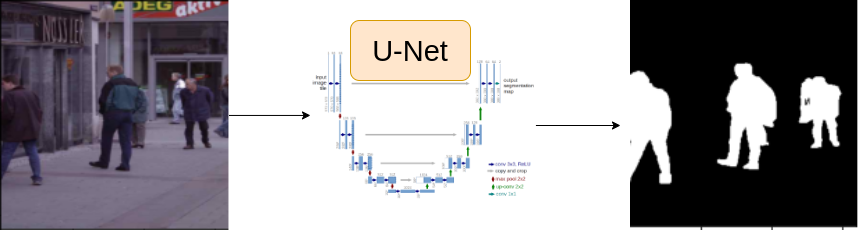

# Some Common Imports

In [4]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [6]:
CSV_FILE= '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'efficientnet-b0'  # Corrected encoder name
WEIGHTS = 'imagenet'

In [7]:
df= pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row = df.iloc[1]
image_path= row.images
mask_path= row.masks
image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask= cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

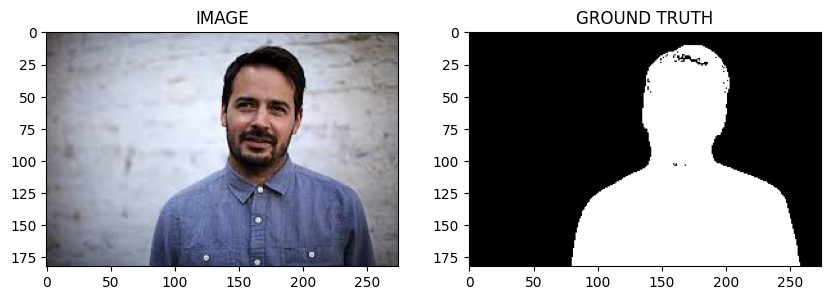

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state= 42)

# Task 3 : Augmentation Functions

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ],
      is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ],
      is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df= df
    self.augmentations= augmentations

  def __len__(self):

    return len(self.df)

  def __getitem__(self, idx):

    row= self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    mask = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask= np.expand_dims(mask, axis =-1)

    if self.augmentations:
      data= self.augmentations(image = image, mask=mask)
      image = data['image']
      mask = data['mask']

      image= np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)


      image = torch.Tensor(image)/255.0
      mask= torch.Tensor(mask)/255.0

      return image, mask


In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset=SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


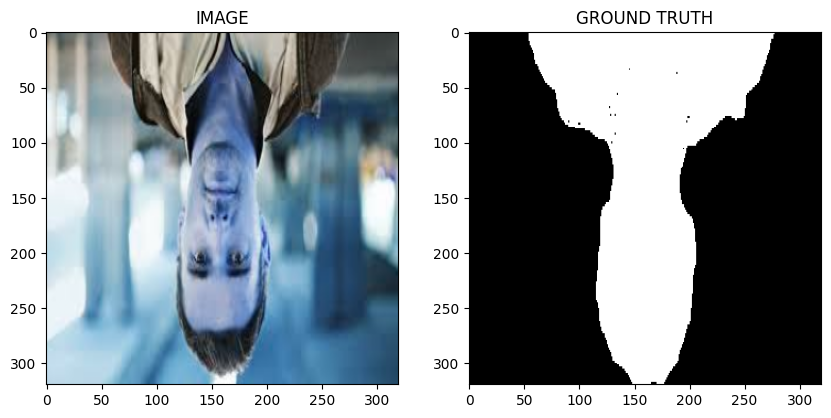

In [17]:
idx = 32

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE , shuffle= True )
validloader = DataLoader(validset, batch_size=BATCH_SIZE)


In [20]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")


total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [21]:
for image, mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

In [22]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.arc(images)

        if masks is not None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [24]:
!pip install timm

In [25]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 198MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): I

# Task 7 : Create Train and Validation Function

In [30]:
def train_fn(data_loader, model , optimizer):

  model.train()
  total_loss= 0.0


  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()


    total_loss +=loss.item()

  return total_loss/len(data_loader)

In [35]:
def eval_fn(data_loader, model ,):

  model.eval()
  total_loss= 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)


      logits, loss = model(images, masks)

      total_loss +=loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [36]:
optimizer = torch.optim.Adam(model.parameters() ,lr= LR)

In [37]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss= train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)


  if valid_loss< best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss


  print(f"Epoch: {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


SAVED-MODEL
Epoch: 1 Train_loss : 0.43863556583722435 Valid_loss : 3.5949718952178955


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


SAVED-MODEL
Epoch: 2 Train_loss : 0.3557648301124573 Valid_loss : 1.1093820333480835


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch: 3 Train_loss : 0.27030491530895234 Valid_loss : 1.245787724852562


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


SAVED-MODEL
Epoch: 4 Train_loss : 0.2711852490901947 Valid_loss : 0.9799253642559052


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


SAVED-MODEL
Epoch: 5 Train_loss : 0.21298822561899822 Valid_loss : 0.846227765083313


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


SAVED-MODEL
Epoch: 6 Train_loss : 0.23153560707966486 Valid_loss : 0.7420631349086761


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


SAVED-MODEL
Epoch: 7 Train_loss : 0.22092360854148865 Valid_loss : 0.6242393851280212


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


SAVED-MODEL
Epoch: 8 Train_loss : 0.18729205131530763 Valid_loss : 0.5849186852574348


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


SAVED-MODEL
Epoch: 9 Train_loss : 0.19122171998023987 Valid_loss : 0.5047037750482559


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch: 10 Train_loss : 0.1791514938076337 Valid_loss : 0.6120997369289398


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


SAVED-MODEL
Epoch: 11 Train_loss : 0.1841292937596639 Valid_loss : 0.30932873860001564


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch: 12 Train_loss : 0.1309210886557897 Valid_loss : 0.3818523697555065


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Epoch: 13 Train_loss : 0.14567509442567825 Valid_loss : 0.36799947172403336


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


Epoch: 14 Train_loss : 0.1328417922059695 Valid_loss : 0.3349331356585026


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


SAVED-MODEL
Epoch: 15 Train_loss : 0.11581922024488449 Valid_loss : 0.24433208256959915


100%|██████████| 4/4 [00:00<00:00,  4.48it/s]


Epoch: 16 Train_loss : 0.11477967500686645 Valid_loss : 0.32506223022937775


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch: 17 Train_loss : 0.14096699108680089 Valid_loss : 0.3546055778861046


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Epoch: 18 Train_loss : 0.13946770777304968 Valid_loss : 0.32241082936525345


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


Epoch: 19 Train_loss : 0.1295665408174197 Valid_loss : 0.3215640038251877


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


SAVED-MODEL
Epoch: 20 Train_loss : 0.1141844575603803 Valid_loss : 0.2300272211432457


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


SAVED-MODEL
Epoch: 21 Train_loss : 0.0965113307038943 Valid_loss : 0.21403872221708298


100%|██████████| 4/4 [00:00<00:00,  4.15it/s]


SAVED-MODEL
Epoch: 22 Train_loss : 0.09406565527121226 Valid_loss : 0.17800703644752502


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch: 23 Train_loss : 0.08479721546173095 Valid_loss : 0.21286055631935596


100%|██████████| 4/4 [00:00<00:00,  4.87it/s]


Epoch: 24 Train_loss : 0.08493699381748836 Valid_loss : 0.18575015850365162


100%|██████████| 4/4 [00:01<00:00,  3.96it/s]

Epoch: 25 Train_loss : 0.08610633338491122 Valid_loss : 0.21041420102119446


# Task 9 : Inference

In [40]:
idx = 27

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask= validset[idx]

logits_mask= model(image.to(DEVICE).unsqueeze(0))  #(C,H,W) -> (1,C,H,W)
pred_mask= torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)* 1.0

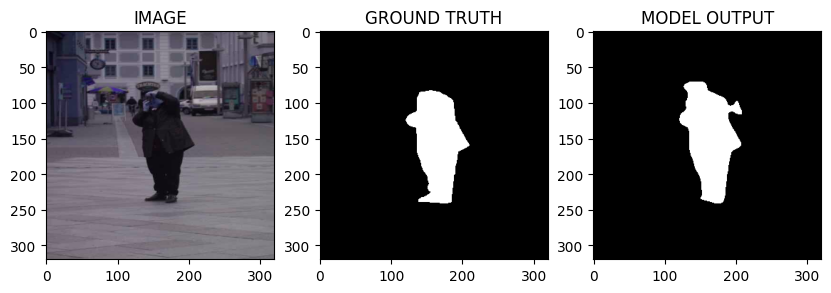

In [41]:
helper.show_image(image, mask,  pred_mask.detach().cpu().squeeze(0) )